In [1]:
pip install pykalman


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 3.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [172]:
df=pd.read_csv('drive/MyDrive/lab4/Eximbank.csv')
df
df1=df.reset_index()['Close']

In [173]:
df

,Date,Open,High,Low,Close,Volume
0,2019-03-01 00:00:00+07:00,12323.44629,12429.37891,12005.64941,12217.51367,101102
1,2019-03-04 00:00:00+07:00,12217.51367,12711.86426,12146.89258,12570.62109,1698208
2,2019-03-05 00:00:00+07:00,12570.62109,12570.62109,12252.82520,12252.82520,1940443
3,2019-03-06 00:00:00+07:00,12535.31055,12535.31055,12252.82520,12288.13574,40228
4,2019-03-07 00:00:00+07:00,12076.27148,12288.13574,12005.64941,12076.27148,4753044
...,...,...,...,...,...,...
1301,2024-05-27 00:00:00+07:00,18000.00000,18850.00000,17900.00000,18800.00000,23321600
1302,2024-05-28 00:00:00+07:00,18900.00000,18950.00000,18550.00000,18750.00000,14183500
1303,2024-05-29 00:00:00+07:00,18750.00000,19700.00000,18600.00000,19650.00000,34878400
1304,2024-05-30 00:00:00+07:00,19400.00000,19750.00000,19300.00000,19700.00000,17593880


In [174]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [175]:
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [176]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [177]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest= create_dataset(test_data, time_step)

In [178]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)



(813, 100)
(813,)
(291, 100)
(291,)


In [179]:
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=X_train[0][0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

In [180]:
kf = kf.em(X_train[0])

In [181]:
test_data.shape

(392, 1)

In [182]:
test_observed = test_data
test_predicted, _ = kf.filter(test_observed)


In [183]:
test_predicted.shape

(392, 1)

In [184]:
test_predicted=scaler.inverse_transform(test_predicted)
ytest=ytest.reshape(-1,1)
ytest=scaler.inverse_transform(test_data)

In [185]:
test_rmse = np.sqrt(np.mean((test_predicted - ytest)**2))
test_mae = mean_absolute_error(test_predicted, ytest)
test_mape = np.mean(np.abs(test_predicted - ytest)/np.abs(test_predicted))*100

In [186]:
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 593.3615134030198
Testing MAPE: 0.9872274525806178
Testing MAE: 179.2417962026885


In [187]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape[1]

332

In [188]:
test_data[60:].shape

(332, 1)

In [189]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        #print(x_input)
        yhat, _ = kf.filter(x_input)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat[-1].tolist())
        i=i+1
    else:
        x_input = x_input.reshape(n_steps)
        yhat, _ = kf.filter(x_input)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat[-1].tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 0.18658857 0.17843937 0.1728368  0.17487409 0.15755708 0.14125871
 0.14889857 0.13769344 0.14787993 0.15847386 0.15786267 0.17069765
 0.16458576 0.16336338 0.15786267 0.14625008 0.14380533 0.14380533
 0.14808365 0.14380533 0.14686127 0.162141   0.17314238 0.17314238
 0.17436477 0.16947527 0.16030742 0.16825288 0.16886407 0.16275219
 0.15297316 0.1505284  0.15602911 0.15602911 0.15725148 0.15847386
 0.15602911 0.15480673 0.15541792 0.15480673 0.16336338 0.16275219
 0.16336338 0.15969625 0.15725148 0.15725148 0.15908505 0.16275219
 0.16336338 0.16519695 0.16519695 0.162141   0.16764169 0.16519695
 0.15908505 0.15725148 0.15358435 0.15480673 0.15725148 0.15480673
 0.15297316 0.15419554 0.15541792 0.15725148 0.16275219 0.16030742
 0.16030742 0.16091861]
77 day output [[0.15969625]
 [0.23736614]
 [0.27593091]
 [0.29150519]
 [0.31260027]
 [0.32154393]
 [0.32050405]
 [0.31590058]
 [0.31990056]
 [0.34107898]
 [0.35428113]
 [0.35476108]
 [0.37

In [190]:
# Chuyển danh sách thành mảng numpy
values_array = np.array(lst_output)

# Nếu bạn thực sự cần reshape (ví dụ: thành mảng 2D 1 hàng)
values_reshaped = values_array.reshape(-1, 1)

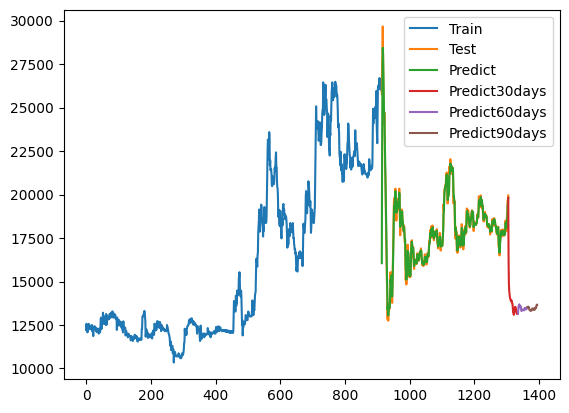

In [191]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,test_predicted)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.show()



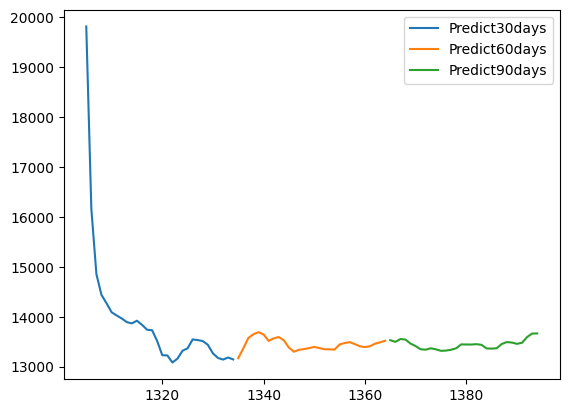

In [192]:


prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(values_reshaped[60:90]))

plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.show()